In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import scanpy as sc
import scipy as sp
import anndata as ad
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
in_dir = '../../results/08_mouse_ssc/03_annotation'
out_dir = '../../results/08_mouse_ssc/04_fib_subclustering'
os.makedirs(out_dir, exist_ok=True)

In [3]:
adata = sc.read_h5ad(f'{in_dir}/adata.h5ad')

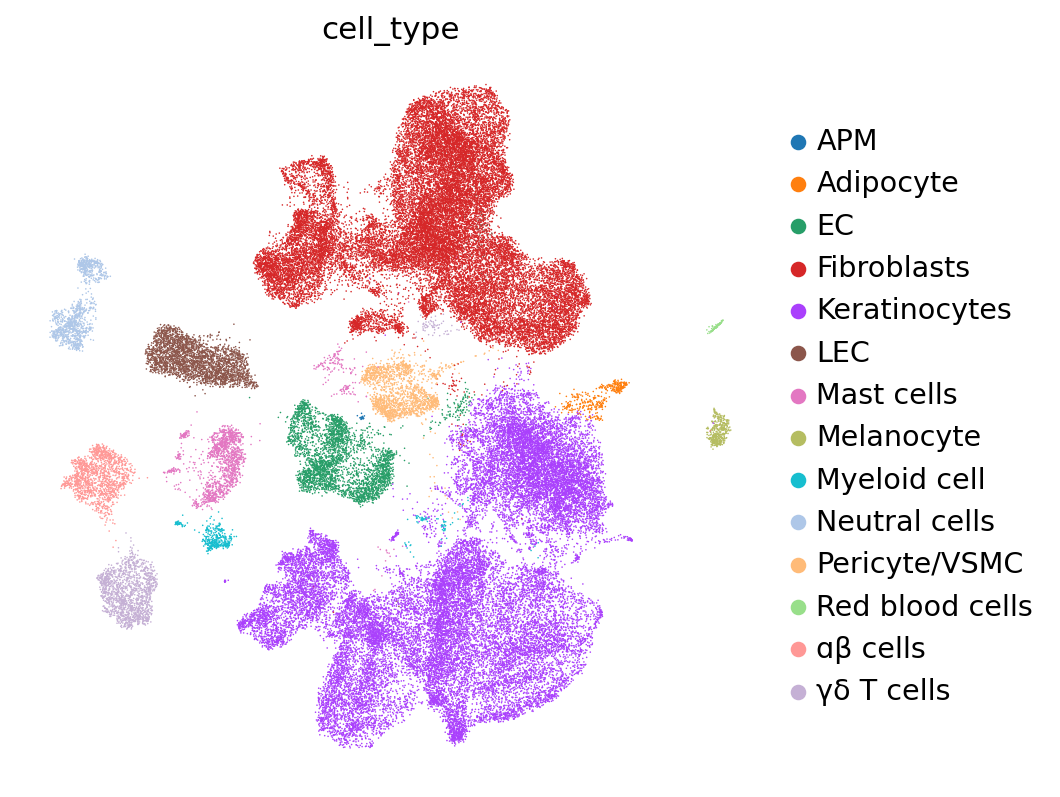

In [4]:
sc.set_figure_params(figsize=(6, 6))

sc.pl.umap(adata, color=["cell_type"], size=2, frameon=False)

In [5]:
# subset all fibroblast cells
adata_fib = adata[adata.obs['cell_type'].isin(['Fibroblasts']), :].copy()

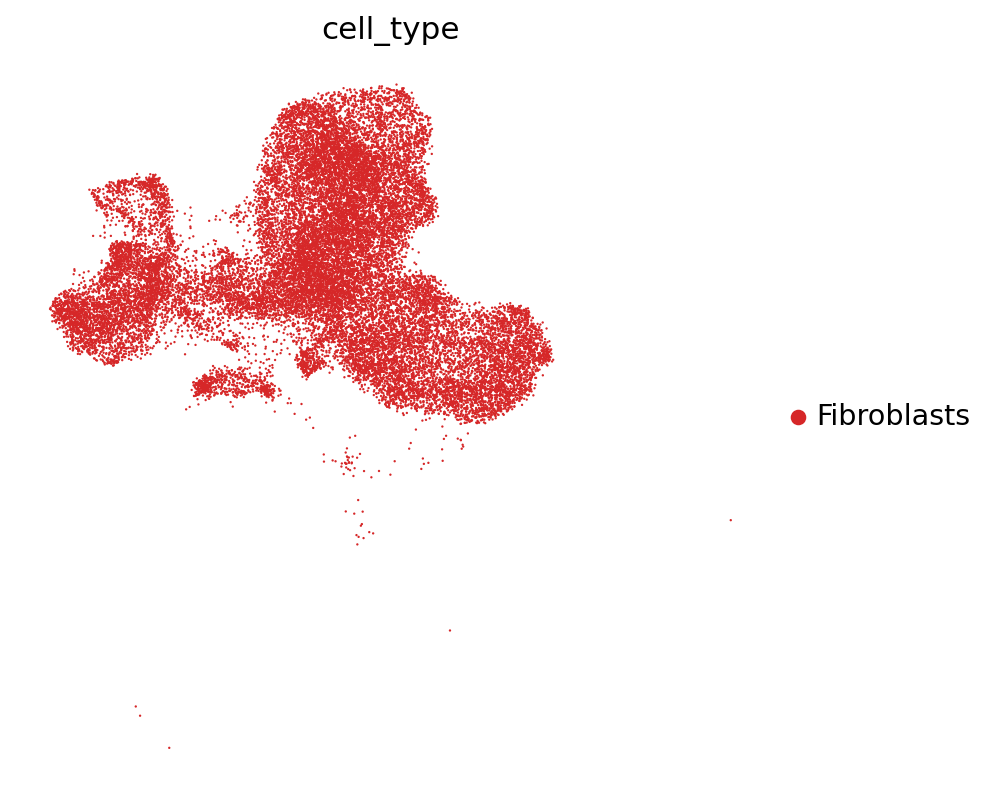

In [6]:
sc.pl.umap(adata_fib, color=['cell_type'], frameon=False)

In [7]:
sc.pp.neighbors(adata_fib)
sc.tl.umap(adata_fib)

2024-12-11 20:53:24.231206: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733950404.249330 4001094 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733950404.254943 4001094 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-11 20:53:24.275247: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


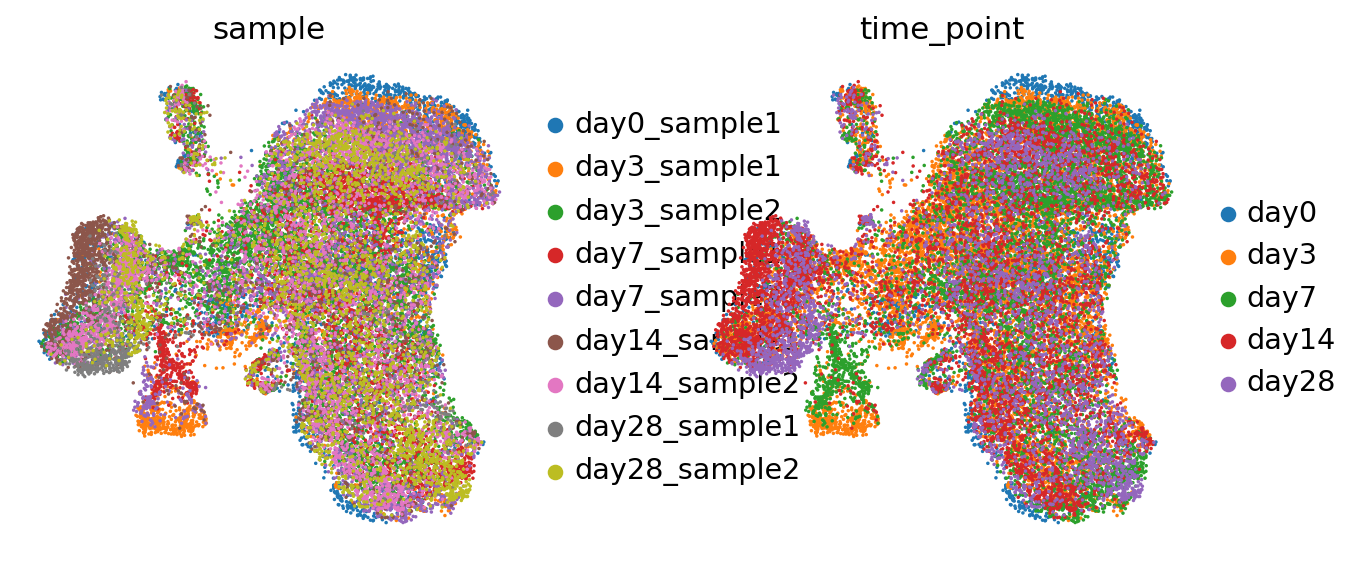

In [8]:
sc.set_figure_params(figsize=(4, 4))

sc.pl.umap(adata_fib, color=['sample', 'time_point'], frameon=False, size=10)

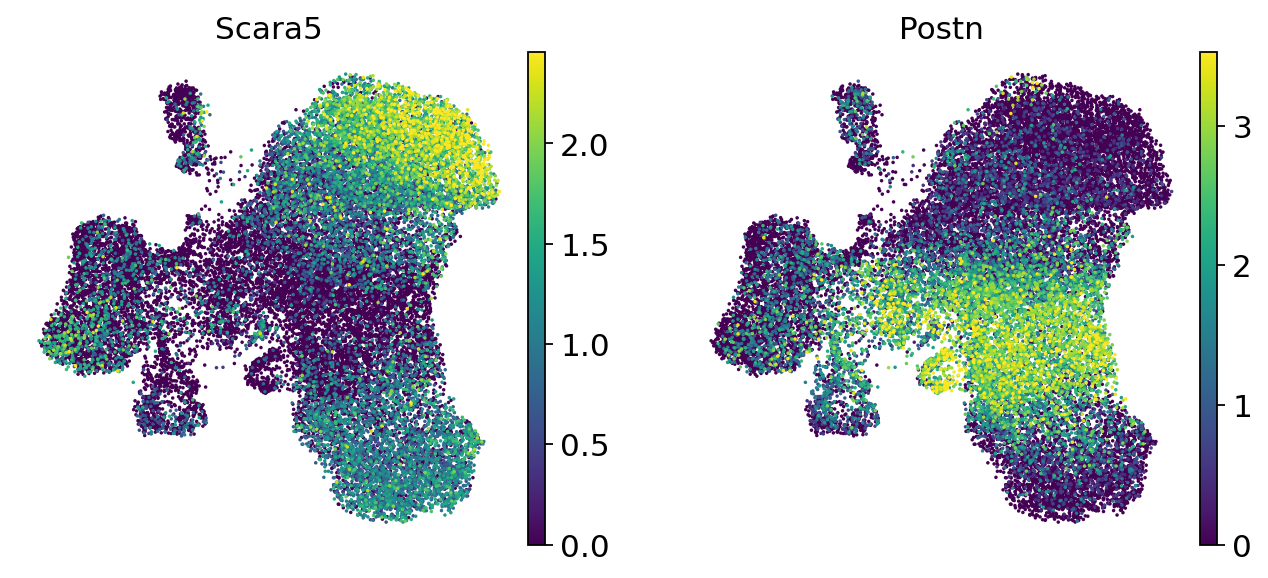

In [9]:
sc.pl.umap(adata_fib, color=['Scara5', 'Postn'], frameon=False, 
           vmax='p99', vmin='p1', size=10, use_raw=False)

In [10]:
sc.tl.leiden(adata_fib, key_added="leiden", resolution=0.5)

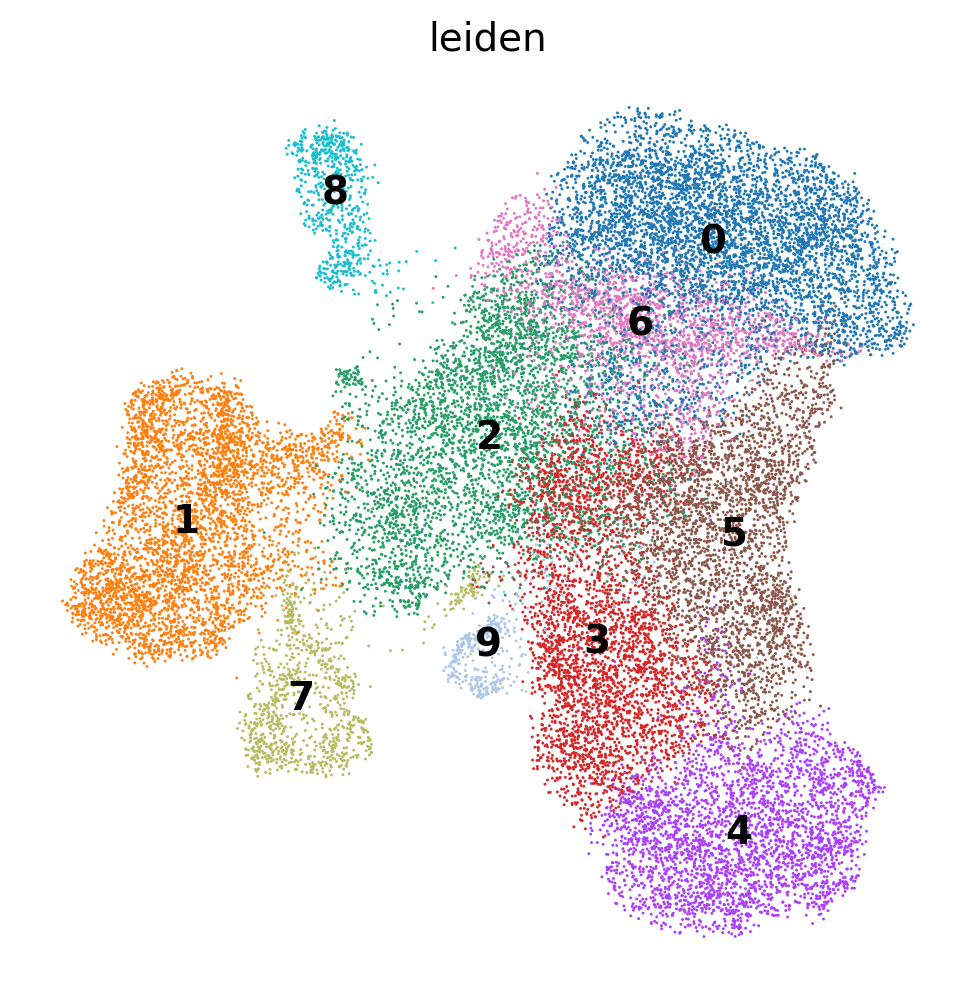

In [11]:
sc.set_figure_params(figsize=(6, 6), dpi=100, dpi_save=300, vector_friendly=True)

sc.pl.umap(adata_fib, color=['leiden'], frameon=False, legend_loc='on data')

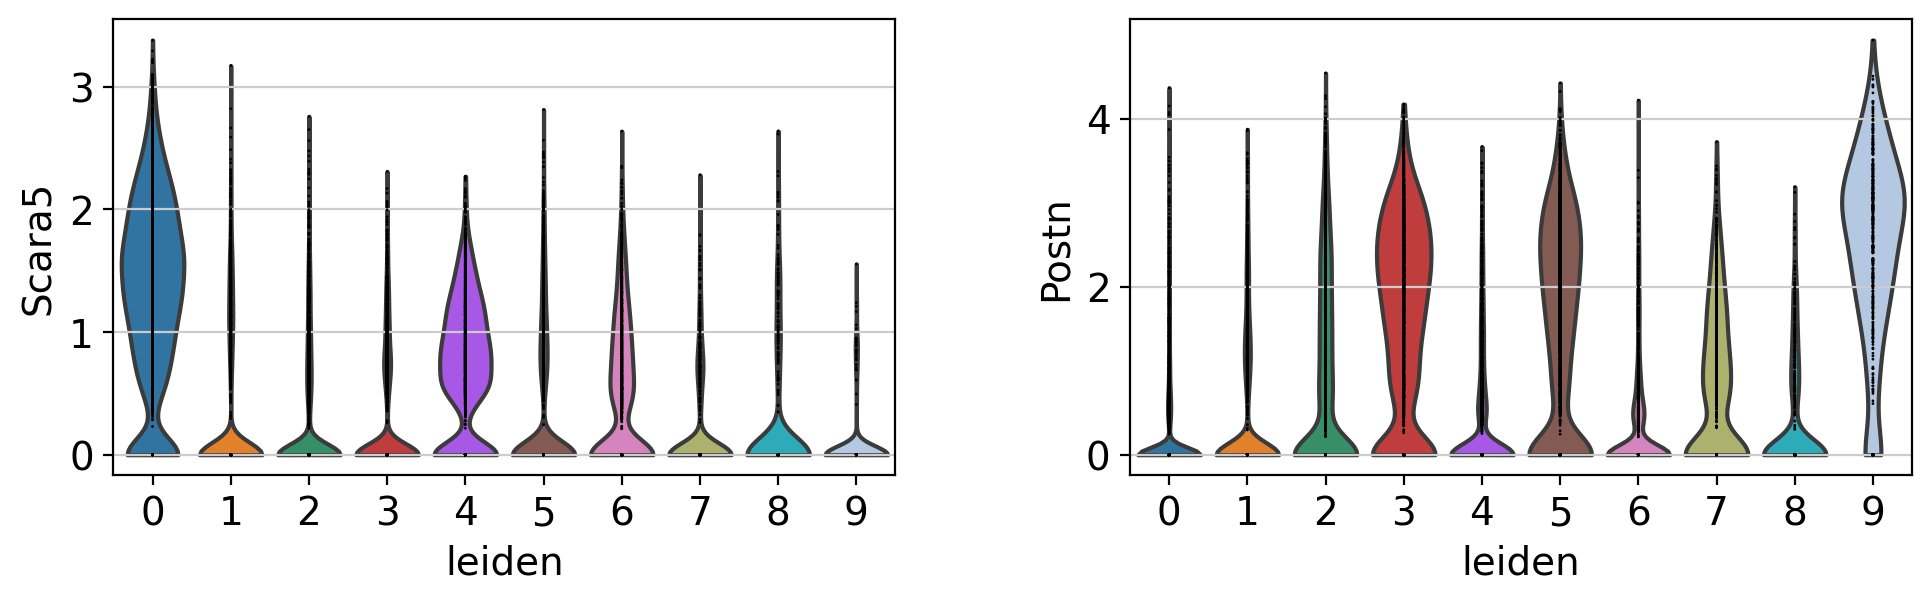

In [12]:
sc.set_figure_params(figsize=(5, 3), dpi=100, dpi_save=300, vector_friendly=True)

sc.pl.violin(adata_fib, keys=["Scara5", "Postn"], groupby="leiden", use_raw=False, jitter=False)

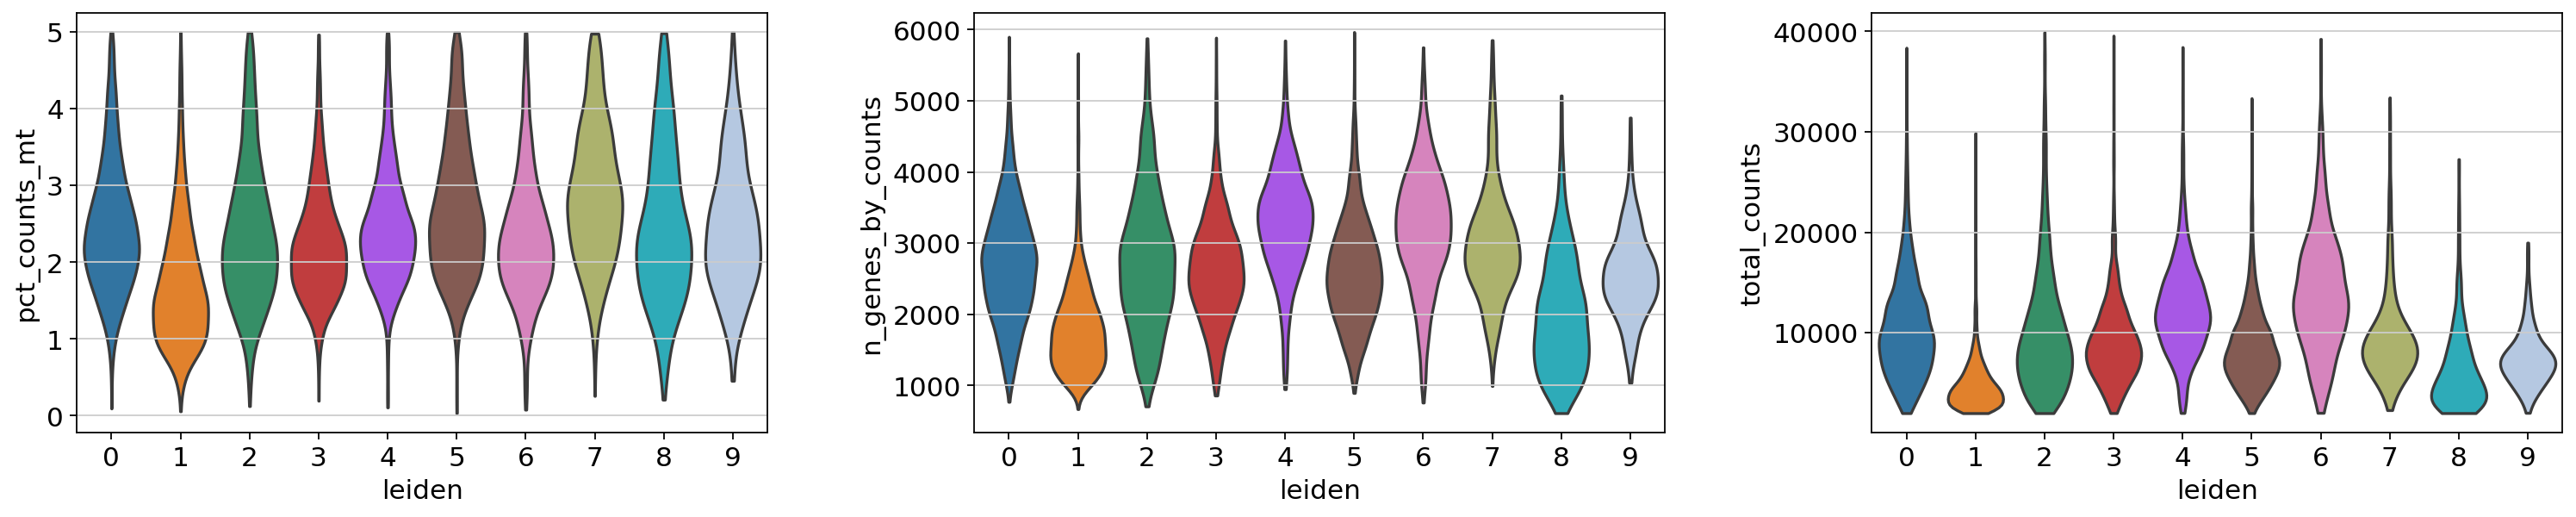

In [13]:
sc.set_figure_params(figsize=(6, 4))

sc.pl.violin(adata_fib, ['pct_counts_mt', 'n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True, groupby='leiden', size=0)

In [14]:
adata_fib = adata_fib[adata_fib.obs["leiden"] != "1"]

In [15]:
# for conveniences, we here rename the sub-clusters as Fib1 to Fib10
adata_fib.obs['sub_clusters'] = adata_fib.obs['leiden']
adata_fib.obs['sub_clusters'] = adata_fib.obs['sub_clusters'].str.replace(r'\b0\b', 'Fib1', regex=True)
adata_fib.obs['sub_clusters'] = adata_fib.obs['sub_clusters'].str.replace(r'\b2\b', 'Fib2', regex=True)
adata_fib.obs['sub_clusters'] = adata_fib.obs['sub_clusters'].str.replace(r'\b3\b', 'Fib3', regex=True)
adata_fib.obs['sub_clusters'] = adata_fib.obs['sub_clusters'].str.replace(r'\b4\b', 'Fib4', regex=True)
adata_fib.obs['sub_clusters'] = adata_fib.obs['sub_clusters'].str.replace(r'\b5\b', 'Fib5', regex=True)
adata_fib.obs['sub_clusters'] = adata_fib.obs['sub_clusters'].str.replace(r'\b6\b', 'Fib6', regex=True)
adata_fib.obs['sub_clusters'] = adata_fib.obs['sub_clusters'].str.replace(r'\b7\b', 'Fib7', regex=True)
adata_fib.obs['sub_clusters'] = adata_fib.obs['sub_clusters'].str.replace(r'\b8\b', 'Fib8', regex=True)
adata_fib.obs['sub_clusters'] = adata_fib.obs['sub_clusters'].str.replace(r'\b9\b', 'Fib9', regex=True)

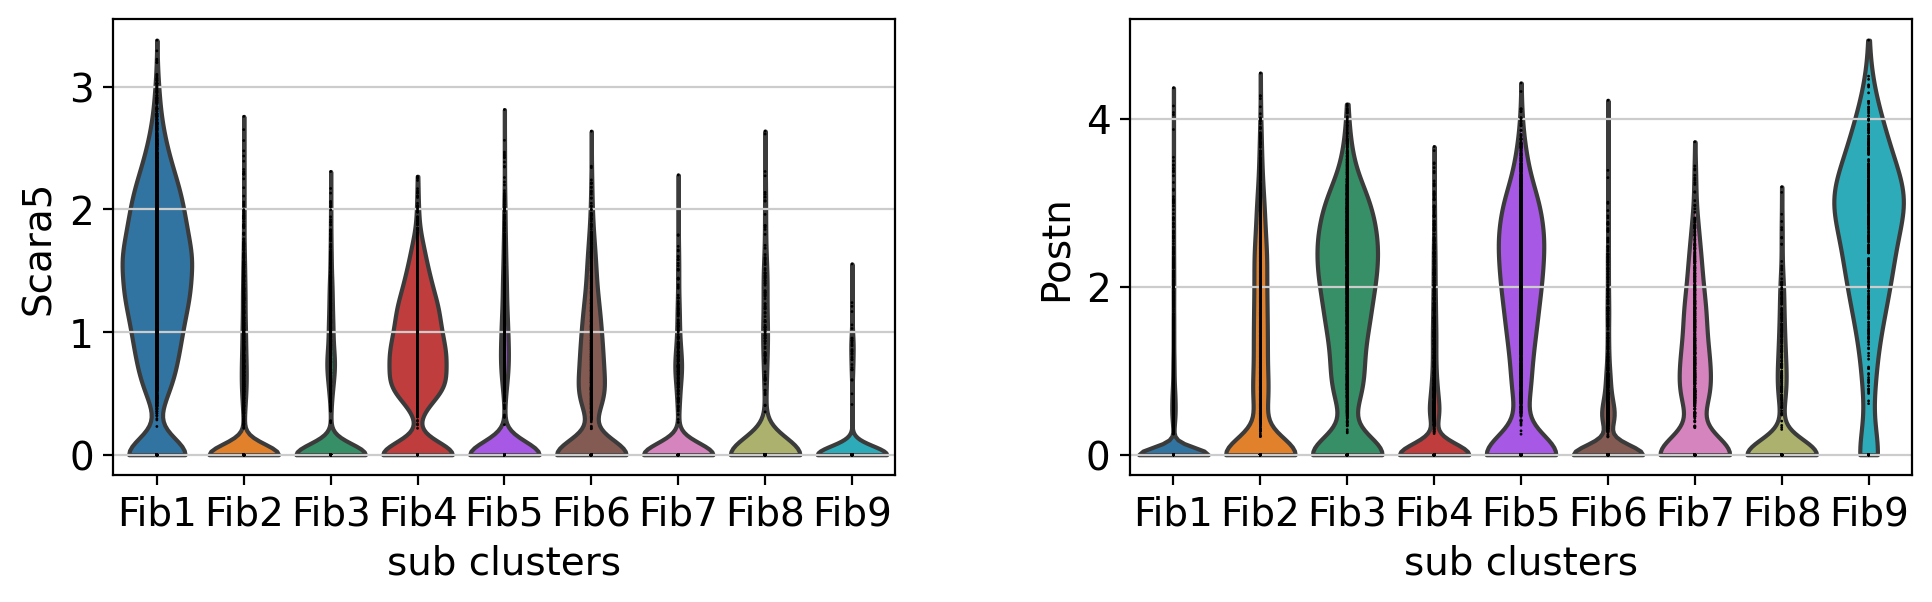

In [16]:
sc.set_figure_params(figsize=(5, 3), dpi=100, dpi_save=300, vector_friendly=True)

sc.pl.violin(adata_fib, keys=["Scara5", "Postn"], groupby="sub_clusters", use_raw=False, jitter=False)

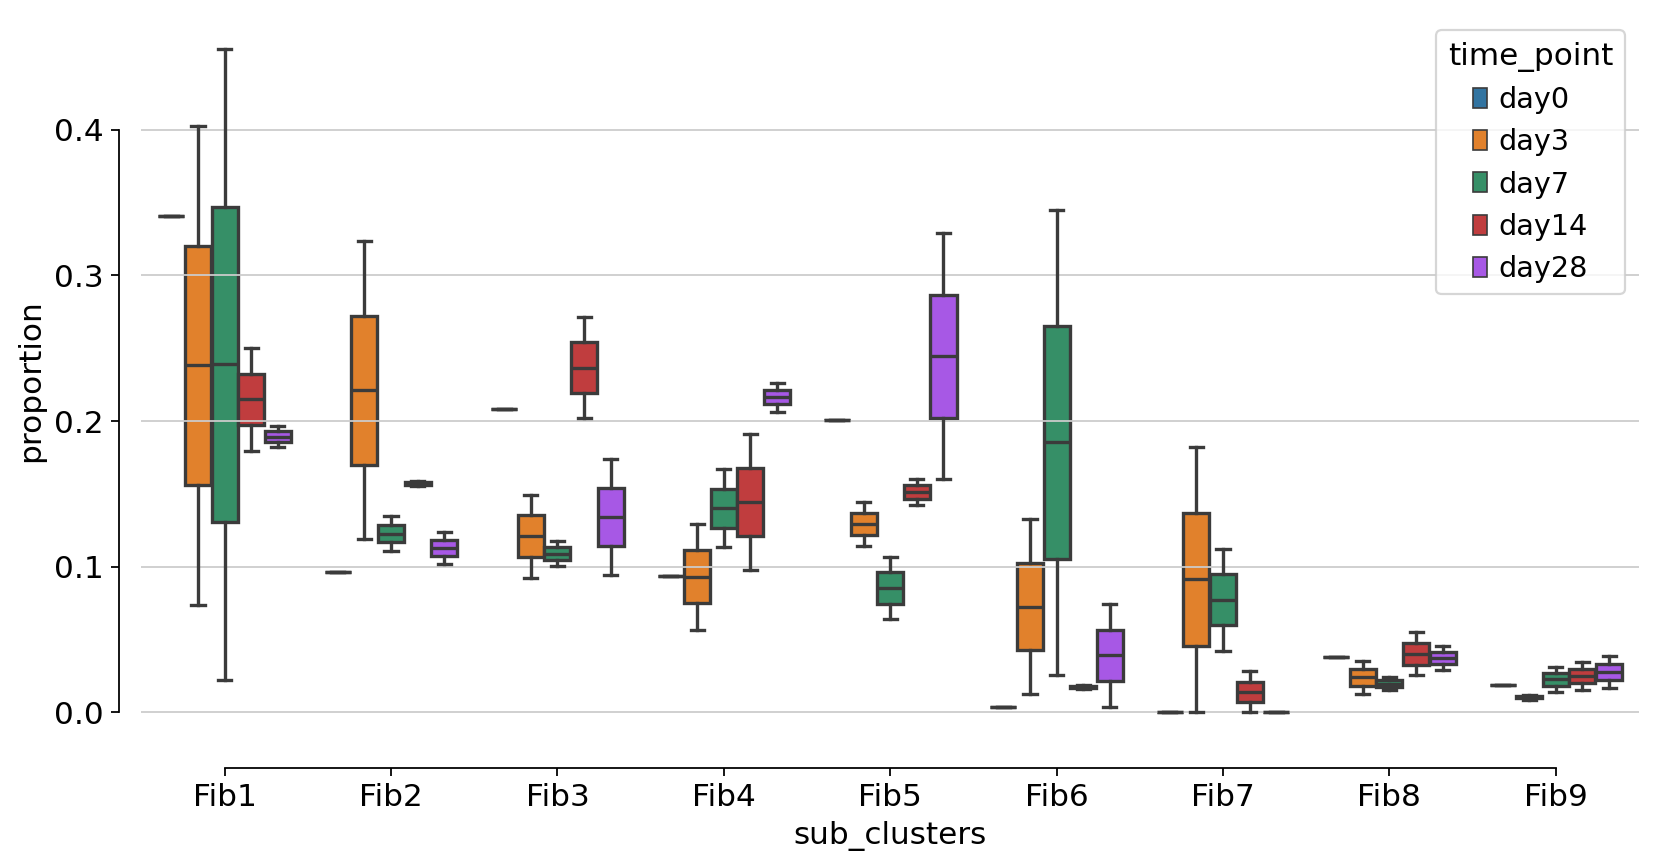

In [17]:
# we can compute the cell-type composition between control and SSc
df_prop = pd.crosstab(adata_fib.obs['sample'],adata_fib.obs['sub_clusters'], normalize='index').reset_index()
df_obs = adata_fib.obs[['sample', 'time_point']].drop_duplicates()
df_prop = pd.melt(df_prop, id_vars=['sample'], value_name='proportion')
df = df_prop.merge(df_obs)

# visualize cell type proportion
sc.set_figure_params(figsize=(12, 6))
ax = sns.boxplot(data=df, 
                 x='sub_clusters', y='proportion', 
                 hue="time_point", 
                 showfliers = False)
sns.despine(offset=10, trim=True, ax=ax)

df.to_csv(f'{out_dir}/cell_propotion.csv')

In [18]:
# find marker genes
adata_fib.uns['log1p']['base'] = None
sc.tl.rank_genes_groups(adata_fib, 'sub_clusters', method='wilcoxon', use_raw=False)
result = adata_fib.uns['rank_genes_groups']

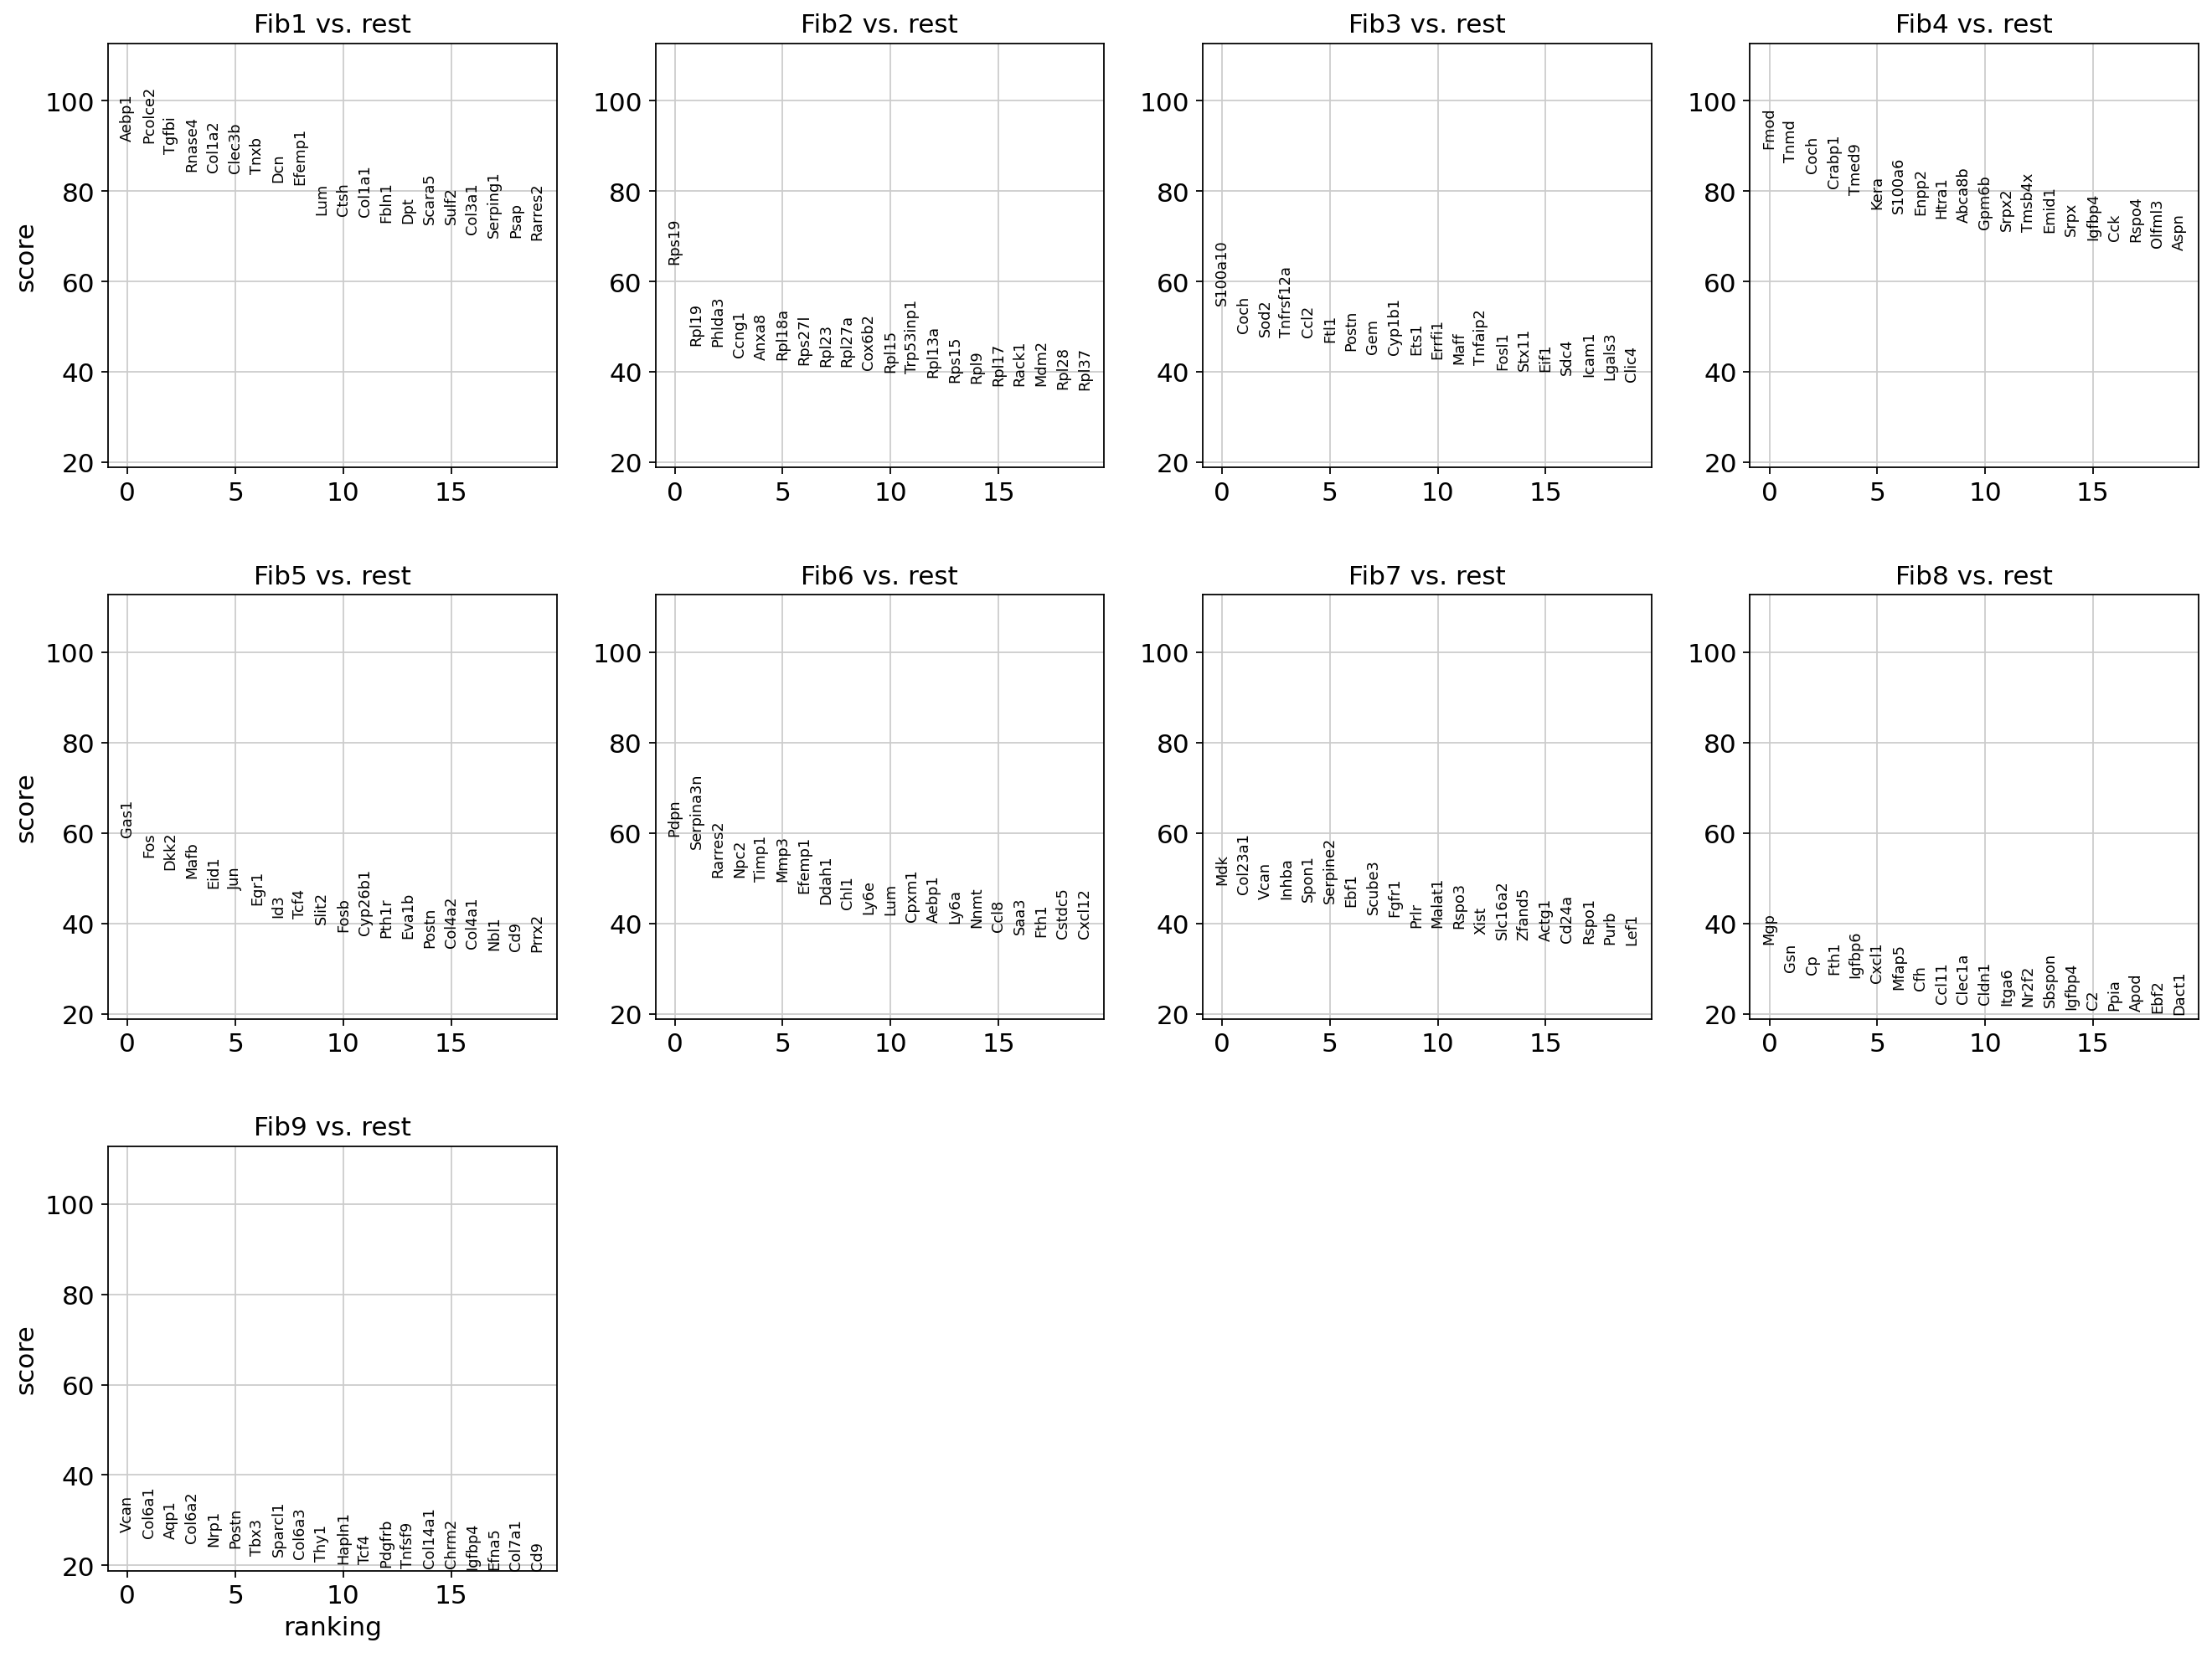

In [19]:
sc.set_figure_params(figsize=(5, 5))
sc.pl.rank_genes_groups(adata_fib)

In [20]:
df = pd.DataFrame(adata_fib.uns['rank_genes_groups']['names']).head(200)

# Extract marker genes, log fold changes, and p-values
results = []
for cluster in adata_fib.uns['rank_genes_groups']['names'].dtype.names:
    cluster_marker_genes = adata_fib.uns['rank_genes_groups']['names'][cluster]
    logfoldchanges = adata_fib.uns['rank_genes_groups']['logfoldchanges'][cluster]
    pvals = adata_fib.uns['rank_genes_groups']['pvals'][cluster]
    pvals_adj = adata_fib.uns['rank_genes_groups']['pvals_adj'][cluster]
    
    for gene, logfc, pval, pval_adj in zip(cluster_marker_genes, logfoldchanges, pvals, pvals_adj):
        results.append({
            'gene': gene,
            'log fold change': logfc,
            'p-value': pval,
            'adjusted p-value': pval_adj,
            'cluster': cluster
        })
        
# Convert to DataFrame
markers_df = pd.DataFrame(results)

In [21]:
markers_df.head()

gene  log fold change  p-value  adjusted p-value cluster
0    Aebp1         2.911557      0.0               0.0    Fib1
1  Pcolce2         3.376765      0.0               0.0    Fib1
2    Tgfbi         3.149946      0.0               0.0    Fib1
3   Rnase4         1.943059      0.0               0.0    Fib1
4   Col1a2         2.283989      0.0               0.0    Fib1

In [22]:
markers_df.to_csv(f'{out_dir}/top_200_markers.csv', index=False)

In [23]:
adata_fib.write_h5ad(f'{out_dir}/adata.h5ad')